In [ ]:

import json, re, uuid, pathlib, math
from collections import Counter

BASE = pathlib.Path(".")
DATASET = BASE / "dataset"; DATASET.mkdir(exist_ok=True, parents=True)
EVAL = BASE / "eval"; EVAL.mkdir(exist_ok=True, parents=True)
ANS = EVAL / "answer_keys"; ANS.mkdir(exist_ok=True, parents=True)
RUNS = EVAL / "runs"; RUNS.mkdir(exist_ok=True, parents=True)
SCHEMAS = EVAL / "schemas"; SCHEMAS.mkdir(exist_ok=True, parents=True)


PATH_POWER = DATASET / ""
PATH_NERC  = DATASET / ""
PATH_REASON= DATASET / ""

print("Looking for:", PATH_POWER, PATH_NERC, PATH_REASON)

# ==== 2) Parser: supports either Q/A blocks OR single-line questions ====
def parse_blocks(text):
    """
    Accepts blocks separated by blank lines.
    Inside a block, will look for lines beginning with 'Q:'/'Question:' and 'A:'/'Answer:' (case-insensitive).
    If only one non-empty line exists, treat it as a question with empty answer.
    """
    blocks = re.split(r'\n\s*\n+', text.strip())
    qa = []
    for b in blocks:
        q = re.search(r'(?i)^(?:q(?:uestion)?):\s*(.*)', b, re.M)
        a = re.search(r'(?i)^(?:a(?:nswer)?):\s*(.*)', b, re.M)
        if q:
            qa.append((q.group(1).strip(), a.group(1).strip() if a else ""))
        else:
            lines = [ln.strip() for ln in b.splitlines() if ln.strip()]
            if len(lines)==1:
                qa.append((lines[0], ""))
            elif len(lines)>=2:

                qa.append((lines[0], lines[-1]))
    return qa

def write_jsonl(pairs, subset, out_path):
    with open(out_path, "w", encoding="utf-8") as f:
        for i,(q,a) in enumerate(pairs, 1):
            item = {
                "id": f"{subset}-{i:05d}",
                "subset": subset,
                "question": q,
                "answer": a,
                "metadata":
            }
            f.write(json.dumps(item, ensure_ascii=False) + "\n")

def read_text_if_exists(path: pathlib.Path):
    if not path.exists():
        print(f"WARNING: {path} not found. Create/upload it or change PATH_* above.")
        return ""
    return path.read_text(encoding="utf-8")

# ==== 3) Build JSONL answer keys from your three .txt files ====
txt_power   = read_text_if_exists(PATH_POWER)
txt_nerc    = read_text_if_exists(PATH_NERC)
txt_reason  = read_text_if_exists(PATH_REASON)

pairs_power  = parse_blocks(txt_power)   if txt_power   else []
pairs_nerc   = parse_blocks(txt_nerc)    if txt_nerc    else []
pairs_reason = parse_blocks(txt_reason)  if txt_reason  else []

write_jsonl(pairs_power,  "power",    ANS/"power_answers.jsonl")
write_jsonl(pairs_nerc,   "nerc",     ANS/"nerc_answers.jsonl")
write_jsonl(pairs_reason, "reasoning", ANS/"reasoning_answers.jsonl")

print("Answer keys written to:", ANS)

# ==== 4) Scoring utilities (SQuAD-style + power-systems add-ons) ====
ARTICLES = {"a","an","the"}
def _normalize(s: str):
    s = s.lower()
    s = re.sub(r"[^a-z0-9%.\-+/×*_=Ωμσπ· ]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()

    toks = s.split()
    if toks and toks[0] in ARTICLES:
        toks = toks[1:]
    return " ".join(toks)

def exact_match(pred, gold):
    return int(_normalize(pred) == _normalize(gold))

def f1(pred, gold):
    p = _normalize(pred).split()
    g = _normalize(gold).split()
    if not p and not g: return 1.0
    if not p or not g:  return 0.0
    cp, cg = Counter(p), Counter(g)
    overlap = sum((cp & cg).values())
    prec = overlap / max(1, sum(cp.values()))
    rec  = overlap / max(1, sum(cg.values()))
    return 0.0 if (prec+rec)==0 else 2*prec*rec/(prec+rec)

_num_pat = re.compile(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?')
def _first_num(s):
    m = _num_pat.search(s.replace(",", ""))
    return float(m.group()) if m else None

def numeric_ok(pred, gold, tol_abs=1e-3, tol_rel=0.01):
    pn = _first_num(pred); gn = _first_num(gold)
    if pn is None or gn is None: return None
    if abs(pn - gn) <= tol_abs: return True
    if abs(gn) > 1e-12 and abs(pn-gn)/abs(gn) <= tol_rel: return True
    return False

def keyword_recall(pred, required_tokens):
    if not required_tokens: return None
    p = _normalize(pred)
    hits = sum(1 for t in required_tokens if t.lower() in p)
    return hits / len(required_tokens)

def load_jsonl(path):
    return [json.loads(l) for l in pathlib.Path(path).read_text(encoding="utf-8").splitlines() if l.strip()]

def join_gold_pred(gold_path, pred_path):
    gold = {x["id"]: x for x in load_jsonl(gold_path)}
    pred = {x["id"]: x for x in load_jsonl(pred_path)} if pathlib.Path(pred_path).exists() else {}
    ids = sorted(gold.keys())
    rows = []
    for i in ids:
        g = gold[i]
        p = pred.get(i, {"prediction": ""})
        rows.append((g, p))
    return rows

def evaluate_split(gold_path, pred_path, subset_name):
    rows = join_gold_pred(gold_path, pred_path)
    n = len(rows) or 1
    em = f1s = 0.0
    num_hit = 0; num_total = 0
    kw_sum = 0.0; kw_total = 0
    for g, p in rows:
        pred = p.get("prediction","")
        gold = g.get("answer","")
        em += exact_match(pred, gold)
        f1s += f1(pred, gold)
        # numeric checks
        tol_abs = g.get("metadata",{}).get("tol_abs", 1e-3)
        tol_rel = g.get("metadata",{}).get("tol_rel", 0.01)
        nres = numeric_ok(pred, gold, tol_abs, tol_rel)
        if nres is not None:
            num_total += 1
            num_hit += int(nres)
        # keyword recall
        req = g.get("metadata",{}).get("required", [])
        kr = keyword_recall(pred, req)
        if kr is not None:
            kw_total += 1
            kw_sum += kr
    out = {
        "subset": subset_name,
        "N": len(rows),
        "EM": em / n,
        "F1": f1s / n,
        "NUM@tol": (num_hit/num_total) if num_total else None,
        "KW_recall": (kw_sum/kw_total) if kw_total else None
    }
    return out

# ==== 5) (Optional) NERC rubric scoring (0–3) ====

DEFAULT_RUBRIC = {
    "root_cause":   ["mutual coupling","uninitialized","patch management","cold weather","sf6 low density","database deploy","time sync","relay setting"],
    "consequence":  ["misoperate","trip","oscillation","loss of visibility","blackstart impact","islanding"],
    "mitigation":   ["startup time delay","retune pss","disable avc","add redundancy","procedural control","patch policy","alarm filtering"]
}
def rubric_score(pred, gmeta, rubric=DEFAULT_RUBRIC):
    exp = gmeta.get("expected", [])
    if not exp: return None
    s = 0
    p = _normalize(pred)
    for bucket in exp:
        keys = rubric.get(bucket, [])
        hit = any(k.lower() in p for k in keys)
        s += int(hit)
    return s

def evaluate_rubric(gold_path, pred_path, subset_name):
    rows = join_gold_pred(gold_path, pred_path)
    total = 0; count = 0
    for g,p in rows:
        sc = rubric_score(p.get("prediction",""), g.get("metadata",{}), DEFAULT_RUBRIC)
        if sc is not None:
            total += sc; count += 1
    return {"subset": subset_name, "rubric_avg": (total/count) if count else None, "count": count}

# ==== 6) Example: make dummy prediction files (you will replace with your model outputs) ====

for name in ["power","nerc","reasoning"]:
    pred_path = RUNS / f"{name}_preds.jsonl"
    if not pred_path.exists():
        with open(pred_path, "w", encoding="utf-8") as f:

            for x in load_jsonl(ANS/f"{name}_answers.jsonl"):
                f.write(json.dumps({"id": x["id"], "prediction": ""}, ensure_ascii=False) + "\n")

# ==== 7) Run evaluation for all three splits ====
results = []
results.append(evaluate_split(ANS/"power_answers.jsonl", RUNS/"power_preds.jsonl", "power"))
results.append(evaluate_split(ANS/"nerc_answers.jsonl", RUNS/"nerc_preds.jsonl", "nerc"))
results.append(evaluate_split(ANS/"reasoning_answers.jsonl", RUNS/"reasoning_preds.jsonl", "reasoning"))
rubrics = []
rubrics.append(evaluate_rubric(ANS/"nerc_answers.jsonl", RUNS/"nerc_preds.jsonl", "nerc"))

print("\n=== SCORES ===")
for r in results: print(r)
print("\n=== NERC Rubric ===")
for r in rubrics: print(r)



Looking for: /content/questions.txt /content/Nerc questions.txt /content/questions reasoning.txt
Answer keys written to: eval/answer_keys

=== SCORES ===
{'subset': 'power', 'N': 586, 'EM': 0.9453924914675768, 'F1': 0.9453924914675768, 'NUM@tol': None, 'KW_recall': None}
{'subset': 'nerc', 'N': 184, 'EM': 0.4891304347826087, 'F1': 0.4891304347826087, 'NUM@tol': None, 'KW_recall': None}
{'subset': 'reasoning', 'N': 4, 'EM': 0.0, 'F1': 0.0, 'NUM@tol': None, 'KW_recall': None}

=== NERC Rubric ===
{'subset': 'nerc', 'rubric_avg': None, 'count': 0}


In [ ]:


import json, re, pathlib, unicodedata
from collections import Counter


BASE = pathlib.Path(".")
EVAL = BASE / "eval"; EVAL.mkdir(exist_ok=True, parents=True)
ANS  = EVAL / "answer_keys"; ANS.mkdir(exist_ok=True, parents=True)
RUNS = EVAL / "runs"; RUNS.mkdir(exist_ok=True, parents=True)


PATH_POWER  = pathlib.Path("/content/questions.txt")
PATH_NERC   = pathlib.Path("/content/Nerc questions.txt")
PATH_REASON = pathlib.Path("/content/questions reasoning.txt")

print("Looking for:", PATH_POWER, PATH_NERC, PATH_REASON)

# -------- Parsing (strict: require Q: and A:) --------
BLK_SPLIT = re.compile(r"\n\s*\n+")
Q_PAT = re.compile(r'(?i)^(?:q(?:uestion)?):\s*(.*)', re.M)
A_PAT = re.compile(r'(?i)^(?:a(?:nswer)?):\s*(.*)', re.M)

def parse_blocks_strict(text: str):
    """
    Split by blank lines. Keep ONLY blocks that have both Q: and A: and a non-empty A:
    Returns (pairs, skipped_count).
    """
    qa = []
    skipped = 0
    if not text or not text.strip():
        return qa, 0
    for b in BLK_SPLIT.split(text.strip()):
        q = Q_PAT.search(b)
        a = A_PAT.search(b)
        if q and a:
            qv = q.group(1).strip()
            av = a.group(1).strip()
            if av:
                qa.append((qv, av))
            else:
                skipped += 1
        else:
            skipped += 1
    return qa, skipped

def read_text(path: pathlib.Path) -> str:
    if not path.exists():
        print(f"[WARN] Missing file: {path}")
        return ""
    return path.read_text(encoding="utf-8")

def write_jsonl(pairs, subset: str, out_path: pathlib.Path):
    with open(out_path, "w", encoding="utf-8") as f:
        for i,(q,a) in enumerate(pairs, 1):
            obj = {
                "id": f"{subset}-{i:05d}",
                "subset": subset,
                "question": q,
                "answer": a,
                "metadata": {}
            }
            f.write(json.dumps(obj, ensure_ascii=False) + "\n")

# -------- Build gold answer keys (no empty answers) --------
txt_power  = read_text(PATH_POWER)
txt_nerc   = read_text(PATH_NERC)
txt_reason = read_text(PATH_REASON)

pairs_power,  skip_p = parse_blocks_strict(txt_power)
pairs_nerc,   skip_n = parse_blocks_strict(txt_nerc)
pairs_reason, skip_r = parse_blocks_strict(txt_reason)

write_jsonl(pairs_power,  "power",    ANS/"power_answers.jsonl")
write_jsonl(pairs_nerc,   "nerc",     ANS/"nerc_answers.jsonl")
write_jsonl(pairs_reason, "reasoning", ANS/"reasoning_answers.jsonl")

print("Answer keys written to:", ANS)
print(f"[INFO] Skipped blocks (missing/empty A:): power={skip_p}, nerc={skip_n}, reasoning={skip_r}")

# -------- Normalization (unicode/units/SQuAD-ish) --------
ARTICLES = {"a","an","the"}

def nfkc(s: str) -> str:
    return unicodedata.normalize("NFKC", s)

def unit_normalize(s: str) -> str:
    # unify common power-system tokens and minus signs
    s = re.sub(r"sf₆|sf6", "sf6", s, flags=re.I)
    s = s.replace("−","-").replace("–","-").replace("—","-")
    return s

def normalize(s: str) -> str:
    s = nfkc(s).lower().strip()
    s = unit_normalize(s)
    # keep typical tech chars, strip the rest
    s = re.sub(r"[^a-z0-9%.\-+/×*= ]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    toks = s.split()
    if toks and toks[0] in ARTICLES:
        toks = toks[1:]
    return " ".join(toks)

def exact_match(pred: str, gold: str) -> int:
    return int(normalize(pred) == normalize(gold))

def f1_score(pred: str, gold: str) -> float:
    p = normalize(pred).split()
    g = normalize(gold).split()
    if not p and not g: return 1.0
    if not p or not g:  return 0.0
    cp, cg = Counter(p), Counter(g)
    overlap = sum((cp & cg).values())
    if overlap == 0: return 0.0
    prec = overlap / len(p)
    rec  = overlap / len(g)
    return 2 * prec * rec / (prec + rec)

# -------- JSONL IO --------
def load_jsonl(path: pathlib.Path):
    return [json.loads(l) for l in open(path, encoding="utf-8") if l.strip()]

# -------- Evaluation (ID-join, skip empties, leakage guard) --------
def join_on_id(gold_path: pathlib.Path, pred_path: pathlib.Path):
    if str(gold_path) == str(pred_path):
        raise RuntimeError(f"[ABORT] gold and pred are the same file: {gold_path}")
    gold = {x["id"]: x["answer"] for x in load_jsonl(gold_path)}
    pred = {x["id"]: x.get("prediction","") for x in load_jsonl(pred_path)}
    rows = []
    missing = 0
    for i, g in gold.items():
        p = pred.get(i)
        if p is None:
            missing += 1
            continue
        rows.append((g, p))
    if missing:
        print(f"[WARN] Missing predictions for {missing} gold IDs in {pred_path.name}")
    return rows

def eval_split(gold_path: pathlib.Path, pred_path: pathlib.Path, subset_name: str):
    rows = join_on_id(gold_path, pred_path)
    total = len(rows)
    skipped = 0
    em_sum = 0.0
    f1_sum = 0.0
    pred_tok_len = 0
    gold_tok_len = 0
    for gold, pred in rows:
        if not gold.strip() or not pred.strip():
            skipped += 1
            continue
        em_sum += exact_match(pred, gold)
        f1_sum += f1_score(pred, gold)
        pred_tok_len += len(normalize(pred).split())
        gold_tok_len += len(normalize(gold).split())
    scored = total - skipped
    out = {
        "subset": subset_name,
        "N": total,
        "skipped_empty_pairs": skipped,
        "scored_pairs": scored,
        "EM": (em_sum / scored) if scored else 0.0,
        "F1": (f1_sum / scored) if scored else 0.0,
    }
    if scored:
        out["len_ratio_pred/ref"] = (pred_tok_len / scored) / max(1e-9, (gold_tok_len / scored))
    return out

# -------- Run evaluation if prediction files exist --------
scores = []
for subset in ["power","nerc","reasoning"]:
    g = ANS / f"{subset}_answers.jsonl"
    p = RUNS / f"{subset}_preds.jsonl"
    if p.exists():
        scores.append(eval_split(g, p, subset))
    else:
        print(f"[INFO] No predictions for subset '{subset}' at {p}. Skipping.")

print("\n=== CLEAN SCORES ===")
for s in scores:
    print(s)


Looking for: /content/questions.txt /content/Nerc questions.txt /content/questions reasoning.txt
Answer keys written to: eval/answer_keys
[INFO] Skipped blocks (missing/empty A:): power=585, nerc=184, reasoning=4
[INFO] No predictions for subset 'power' at eval/runs/power_preds.jsonl. Skipping.
[INFO] No predictions for subset 'nerc' at eval/runs/nerc_preds.jsonl. Skipping.
[INFO] No predictions for subset 'reasoning' at eval/runs/reasoning_preds.jsonl. Skipping.

=== CLEAN SCORES ===


In [1]:
#F1 scome Em scome and bertF1 score power systemm theory

!pip install evaluate bert-score rouge-score nltk


import evaluate
from bert_score import score as bert_scorer
import string
import re
from collections import Counter
import numpy as np

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)
    def white_space_fix(text):
        return ' '.join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()
    return white_space_fix(remove_articles(remove_punc(lower(s))))

def f1_score(prediction, ground_truth):
    """Calculate F1 score between a prediction and a ground truth answer."""
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    if not prediction_tokens or not ground_truth_tokens:
        return 0.0
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0.0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def exact_match_score(prediction, ground_truth):
    """Calculate Exact Match score."""
    return (normalize_answer(prediction) == normalize_answer(ground_truth))

files_to_evaluate = ["Questions Power System Theory.jsonl"]

for file_path in files_to_evaluate:
    print(f"--- Running Evaluations for: {file_path} ---")

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()

        predictions = [line.strip() for i, line in enumerate(lines) if i % 2 == 0]
        references = [line.strip() for i, line in enumerate(lines) if i % 2 != 0]

        if not predictions or len(predictions) != len(references):
            print(f"Warning: Found mismatched numbers of predictions and references. Skipping.\n")
            continue

        print(f"Loaded {len(predictions)} prediction-reference pairs.\n")

        # --- 1. Calculate EM & F1 ---
        print("## 1. Exact Match (EM) and F1 Score ##")
        em_scores = [exact_match_score(p, r) for p, r in zip(predictions, references)]
        f1_scores = [f1_score(p, r) for p, r in zip(predictions, references)]

        print(f"Average Exact Match: {np.mean(em_scores):.4f}")
        print(f"Average F1 Score: {np.mean(f1_scores):.4f}\n")

        # --- 2. Calculate ROUGE ---
        print("## 2. ROUGE Score ##")
        rouge = evaluate.load('rouge')
        rouge_results = rouge.compute(predictions=predictions, references=references)
        print(rouge_results)
        print("\n")

        # --- 3. Calculate BLEU ---
        print("## 3. BLEU Score ##")
        bleu = evaluate.load('bleu')
        # BLEU expects a list of lists for references
        bleu_results = bleu.compute(predictions=predictions, references=[[r] for r in references])
        print(bleu_results)
        print("\n")

        # --- 4. Calculate Semantic Similarity (BERTScore) ---
        print("## 4. Semantic Similarity (BERTScore) ##")
        # verbose=False to keep the output clean for the loop
        P, R, F1 = bert_scorer(predictions, references, lang="en", verbose=False)

        print(f"Average BERTScore Precision: {P.mean():.4f}")
        print(f"Average BERTScore Recall: {R.mean():.4f}")
        print(f"Average BERTScore F1: {F1.mean():.4f}\n")

    except FileNotFoundError:
        print(f"Error: File not found at '{file_path}'. Please make sure it's uploaded.\n")
    except Exception as e:
        print(f"An unexpected error occurred: {e}\n")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.7 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=058dabdd120303dd471cdcc386c7ef2b5c82163f34f9018d6781451ed2abf9f8
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score
--- Running Evaluations for: Questions Power System Theory.jsonl ---
Loaded 26735 prediction-reference pairs.

## 1. Exact Match (EM) and F1 Score ##
Average Exact Match: 0.0000
Average F1 Score: 0.0665

## 2. ROUGE Score ##


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


{'rouge1': np.float64(0.07186230878941952), 'rouge2': np.float64(0.018535096461329455), 'rougeL': np.float64(0.06125847510782807), 'rougeLsum': np.float64(0.06127371745572927)}


## 3. BLEU Score ##


{'bleu': 0.16154458414837566, 'precisions': [0.2404676615719343, 0.17580453013436362, 0.14292052397815738, 0.11271670094237551], 'brevity_penalty': 1.0, 'length_ratio': 1.3570020206468925, 'translation_length': 665524, 'reference_length': 490437}


## 4. Semantic Similarity (BERTScore) ##


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average BERTScore Precision: 0.8358
Average BERTScore Recall: 0.8457
Average BERTScore F1: 0.8399



In [ ]:
import string
import re
from collections import Counter

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def f1_score(prediction, ground_truth):
    """Calculate F1 score between a prediction and a ground truth answer."""
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()

    if not prediction_tokens or not ground_truth_tokens:
        return 0.0

    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())

    if num_same == 0:
        return 0.0

    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def exact_match_score(prediction, ground_truth):
    """Calculate Exact Match score."""
    return (normalize_answer(prediction) == normalize_answer(ground_truth))


files = ["Nerc questions.txt", "questions reasoning.txt", "questions.txt"]

for file_name in files:
    print(f"--- Evaluating file: {file_name} ---")

    try:
        with open(file_name, 'r') as f:
            lines = f.readlines()


        predictions = [line.strip() for i, line in enumerate(lines) if i % 2 == 0]
        references = [line.strip() for i, line in enumerate(lines) if i % 2 != 0]

        if not predictions or not references or len(predictions) != len(references):
            print(f"Warning: Could not parse predictions and references from {file_name}. Skipping.\n")
            continue

        print(f"Found {len(predictions)} prediction/reference pairs.\n")

        total_em = 0
        total_f1 = 0
        for pred, ref in zip(predictions, references):
            em = exact_match_score(pred, ref)
            f1 = f1_score(pred, ref)
            total_em += em
            total_f1 += f1

        avg_em = total_em / len(predictions) if predictions else 0
        avg_f1 = total_f1 / len(predictions) if predictions else 0
        print(f"Average Exact Match (EM): {avg_em:.4f}")
        print(f"Average F1 Score: {avg_f1:.4f}\n")

    except FileNotFoundError:
        print(f"Error: File '{file_name}' not found. Please ensure the file is in the same directory as the script.\n")
    except Exception as e:
        print(f"An error occurred while processing {file_name}: {e}\n")

--- Evaluating file: Nerc questions.txt ---
Found 2494 prediction/reference pairs.

Average Exact Match (EM): 0.0024
Average F1 Score: 0.3454

--- Evaluating file: questions reasoning.txt ---
Found 395 prediction/reference pairs.

Average Exact Match (EM): 0.0000
Average F1 Score: 0.2029

--- Evaluating file: questions.txt ---
Found 27251 prediction/reference pairs.

Average Exact Match (EM): 0.0335
Average F1 Score: 0.0720



In [ ]:
#F1 scome Em scome and bertF1 score power systemm theory  NERC questions
!pip install evaluate bert-score rouge-score nltk


import evaluate
from bert_score import score as bert_scorer
import string
import re
from collections import Counter
import numpy as np

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)
    def white_space_fix(text):
        return ' '.join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()
    return white_space_fix(remove_articles(remove_punc(lower(s))))

def f1_score(prediction, ground_truth):
    """Calculate F1 score between a prediction and a ground truth answer."""
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    if not prediction_tokens or not ground_truth_tokens:
        return 0.0
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0.0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def exact_match_score(prediction, ground_truth):
    """Calculate Exact Match score."""
    return (normalize_answer(prediction) == normalize_answer(ground_truth))


files_to_evaluate = ["Nerc questions.txt"]


for file_path in files_to_evaluate:
    print(f"--- Running Evaluations for: {file_path} ---")

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()

        predictions = [line.strip() for i, line in enumerate(lines) if i % 2 == 0]
        references = [line.strip() for i, line in enumerate(lines) if i % 2 != 0]

        if not predictions or len(predictions) != len(references):
            print(f"Warning: Found mismatched numbers of predictions and references. Skipping.\n")
            continue

        print(f"Loaded {len(predictions)} prediction-reference pairs.\n")

        # --- 1. Calculate EM & F1 ---
        print("## 1. Exact Match (EM) and F1 Score ##")
        em_scores = [exact_match_score(p, r) for p, r in zip(predictions, references)]
        f1_scores = [f1_score(p, r) for p, r in zip(predictions, references)]

        print(f"Average Exact Match: {np.mean(em_scores):.4f}")
        print(f"Average F1 Score: {np.mean(f1_scores):.4f}\n")

        # --- 2. Calculate ROUGE ---
        print("## 2. ROUGE Score ##")
        rouge = evaluate.load('rouge')
        rouge_results = rouge.compute(predictions=predictions, references=references)
        print(rouge_results)
        print("\n")

        # --- 3. Calculate BLEU ---
        print("## 3. BLEU Score ##")
        bleu = evaluate.load('bleu')
        # BLEU expects a list of lists for references
        bleu_results = bleu.compute(predictions=predictions, references=[[r] for r in references])
        print(bleu_results)
        print("\n")

        # --- 4. Calculate Semantic Similarity (BERTScore) ---
        print("## 4. Semantic Similarity (BERTScore) ##")
        # verbose=False to keep the output clean for the loop
        P, R, F1 = bert_scorer(predictions, references, lang="en", verbose=False)

        print(f"Average BERTScore Precision: {P.mean():.4f}")
        print(f"Average BERTScore Recall: {R.mean():.4f}")
        print(f"Average BERTScore F1: {F1.mean():.4f}\n")

    except FileNotFoundError:
        print(f"Error: File not found at '{file_path}'. Please make sure it's uploaded.\n")
    except Exception as e:
        print(f"An unexpected error occurred: {e}\n")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.0 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=eac7d9cf90c623c4465aea581bb44324643fcac1a2e6126e72f11a985c0abec7
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score
--- Running Evaluations for: Nerc questions.txt ---
Loaded 2494 prediction-reference pairs.

## 1. Exact Match (EM) and F1 Score ##
Average Exact Match: 0.0024
Average F1 Score: 0.3454

## 2. ROUGE Score ##


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


{'rouge1': np.float64(0.3497611232215847), 'rouge2': np.float64(0.2062073947067818), 'rougeL': np.float64(0.31585082422855915), 'rougeLsum': np.float64(0.3158284672469806)}


## 3. BLEU Score ##


{'bleu': 0.4064180735542334, 'precisions': [0.5489741155100525, 0.4328167115902965, 0.36897485493230175, 0.3111998595628895], 'brevity_penalty': 1.0, 'length_ratio': 1.0065571863105232, 'translation_length': 121115, 'reference_length': 120326}


## 4. Semantic Similarity (BERTScore) ##


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average BERTScore Precision: 0.8432
Average BERTScore Recall: 0.8441
Average BERTScore F1: 0.8436



In [ ]:
#F1 scome Em scome and bertF1 score Reasoning questions

!pip install evaluate bert-score rouge-score nltk


import evaluate
from bert_score import score as bert_scorer
import string
import re
from collections import Counter
import numpy as np

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)
    def white_space_fix(text):
        return ' '.join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()
    return white_space_fix(remove_articles(remove_punc(lower(s))))

def f1_score(prediction, ground_truth):
    """Calculate F1 score between a prediction and a ground truth answer."""
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    if not prediction_tokens or not ground_truth_tokens:
        return 0.0
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0.0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def exact_match_score(prediction, ground_truth):
    """Calculate Exact Match score."""
    return (normalize_answer(prediction) == normalize_answer(ground_truth))


files_to_evaluate = ["questions reasoning.txt"]

# Step 4: Loop through each file, load data, and run all evaluations
for file_path in files_to_evaluate:
    print(f"--- Running Evaluations for: {file_path} ---")

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()

        # Parse the file: even lines are predictions, odd lines are references
        predictions = [line.strip() for i, line in enumerate(lines) if i % 2 == 0]
        references = [line.strip() for i, line in enumerate(lines) if i % 2 != 0]

        if not predictions or len(predictions) != len(references):
            print(f"Warning: Found mismatched numbers of predictions and references. Skipping.\n")
            continue

        print(f"Loaded {len(predictions)} prediction-reference pairs.\n")

        # --- 1. Calculate EM & F1 ---
        print("## 1. Exact Match (EM) and F1 Score ##")
        em_scores = [exact_match_score(p, r) for p, r in zip(predictions, references)]
        f1_scores = [f1_score(p, r) for p, r in zip(predictions, references)]

        print(f"Average Exact Match: {np.mean(em_scores):.4f}")
        print(f"Average F1 Score: {np.mean(f1_scores):.4f}\n")

        # --- 2. Calculate ROUGE ---
        print("## 2. ROUGE Score ##")
        rouge = evaluate.load('rouge')
        rouge_results = rouge.compute(predictions=predictions, references=references)
        print(rouge_results)
        print("\n")

        # --- 3. Calculate BLEU ---
        print("## 3. BLEU Score ##")
        bleu = evaluate.load('bleu')
        # BLEU expects a list of lists for references
        bleu_results = bleu.compute(predictions=predictions, references=[[r] for r in references])
        print(bleu_results)
        print("\n")

        # --- 4. Calculate Semantic Similarity (BERTScore) ---
        print("## 4. Semantic Similarity (BERTScore) ##")
        # verbose=False to keep the output clean for the loop
        P, R, F1 = bert_scorer(predictions, references, lang="en", verbose=False)

        print(f"Average BERTScore Precision: {P.mean():.4f}")
        print(f"Average BERTScore Recall: {R.mean():.4f}")
        print(f"Average BERTScore F1: {F1.mean():.4f}\n")

    except FileNotFoundError:
        print(f"Error: File not found at '{file_path}'. Please make sure it's uploaded.\n")
    except Exception as e:
        print(f"An unexpected error occurred: {e}\n")

--- Running Evaluations for: questions reasoning.txt ---
Loaded 396 prediction-reference pairs.

## 1. Exact Match (EM) and F1 Score ##
Average Exact Match: 0.0000
Average F1 Score: 0.2031

## 2. ROUGE Score ##
{'rouge1': np.float64(0.26752299970471205), 'rouge2': np.float64(0.04718828045737573), 'rougeL': np.float64(0.18478477680642297), 'rougeLsum': np.float64(0.18442810371736124)}


## 3. BLEU Score ##
{'bleu': 0.16579075187476583, 'precisions': [0.3896280652352458, 0.17697773567029843, 0.12461446503287507, 0.09140719285541878], 'brevity_penalty': 0.9903321479685144, 'length_ratio': 0.9903785818866346, 'translation_length': 42615, 'reference_length': 43029}


## 4. Semantic Similarity (BERTScore) ##


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average BERTScore Precision: 0.8543
Average BERTScore Recall: 0.8538
Average BERTScore F1: 0.8540



In [ ]:
# Step 1: Install spaCy and its English language model
!pip install spacy networkx matplotlib
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 41.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Loaded and processed 27080 Q&A pairs from questions.txt.

Graph built with 1545 nodes and 39430 edges.
Each edge represents terms that appeared together in at least 5 Q&A pairs.



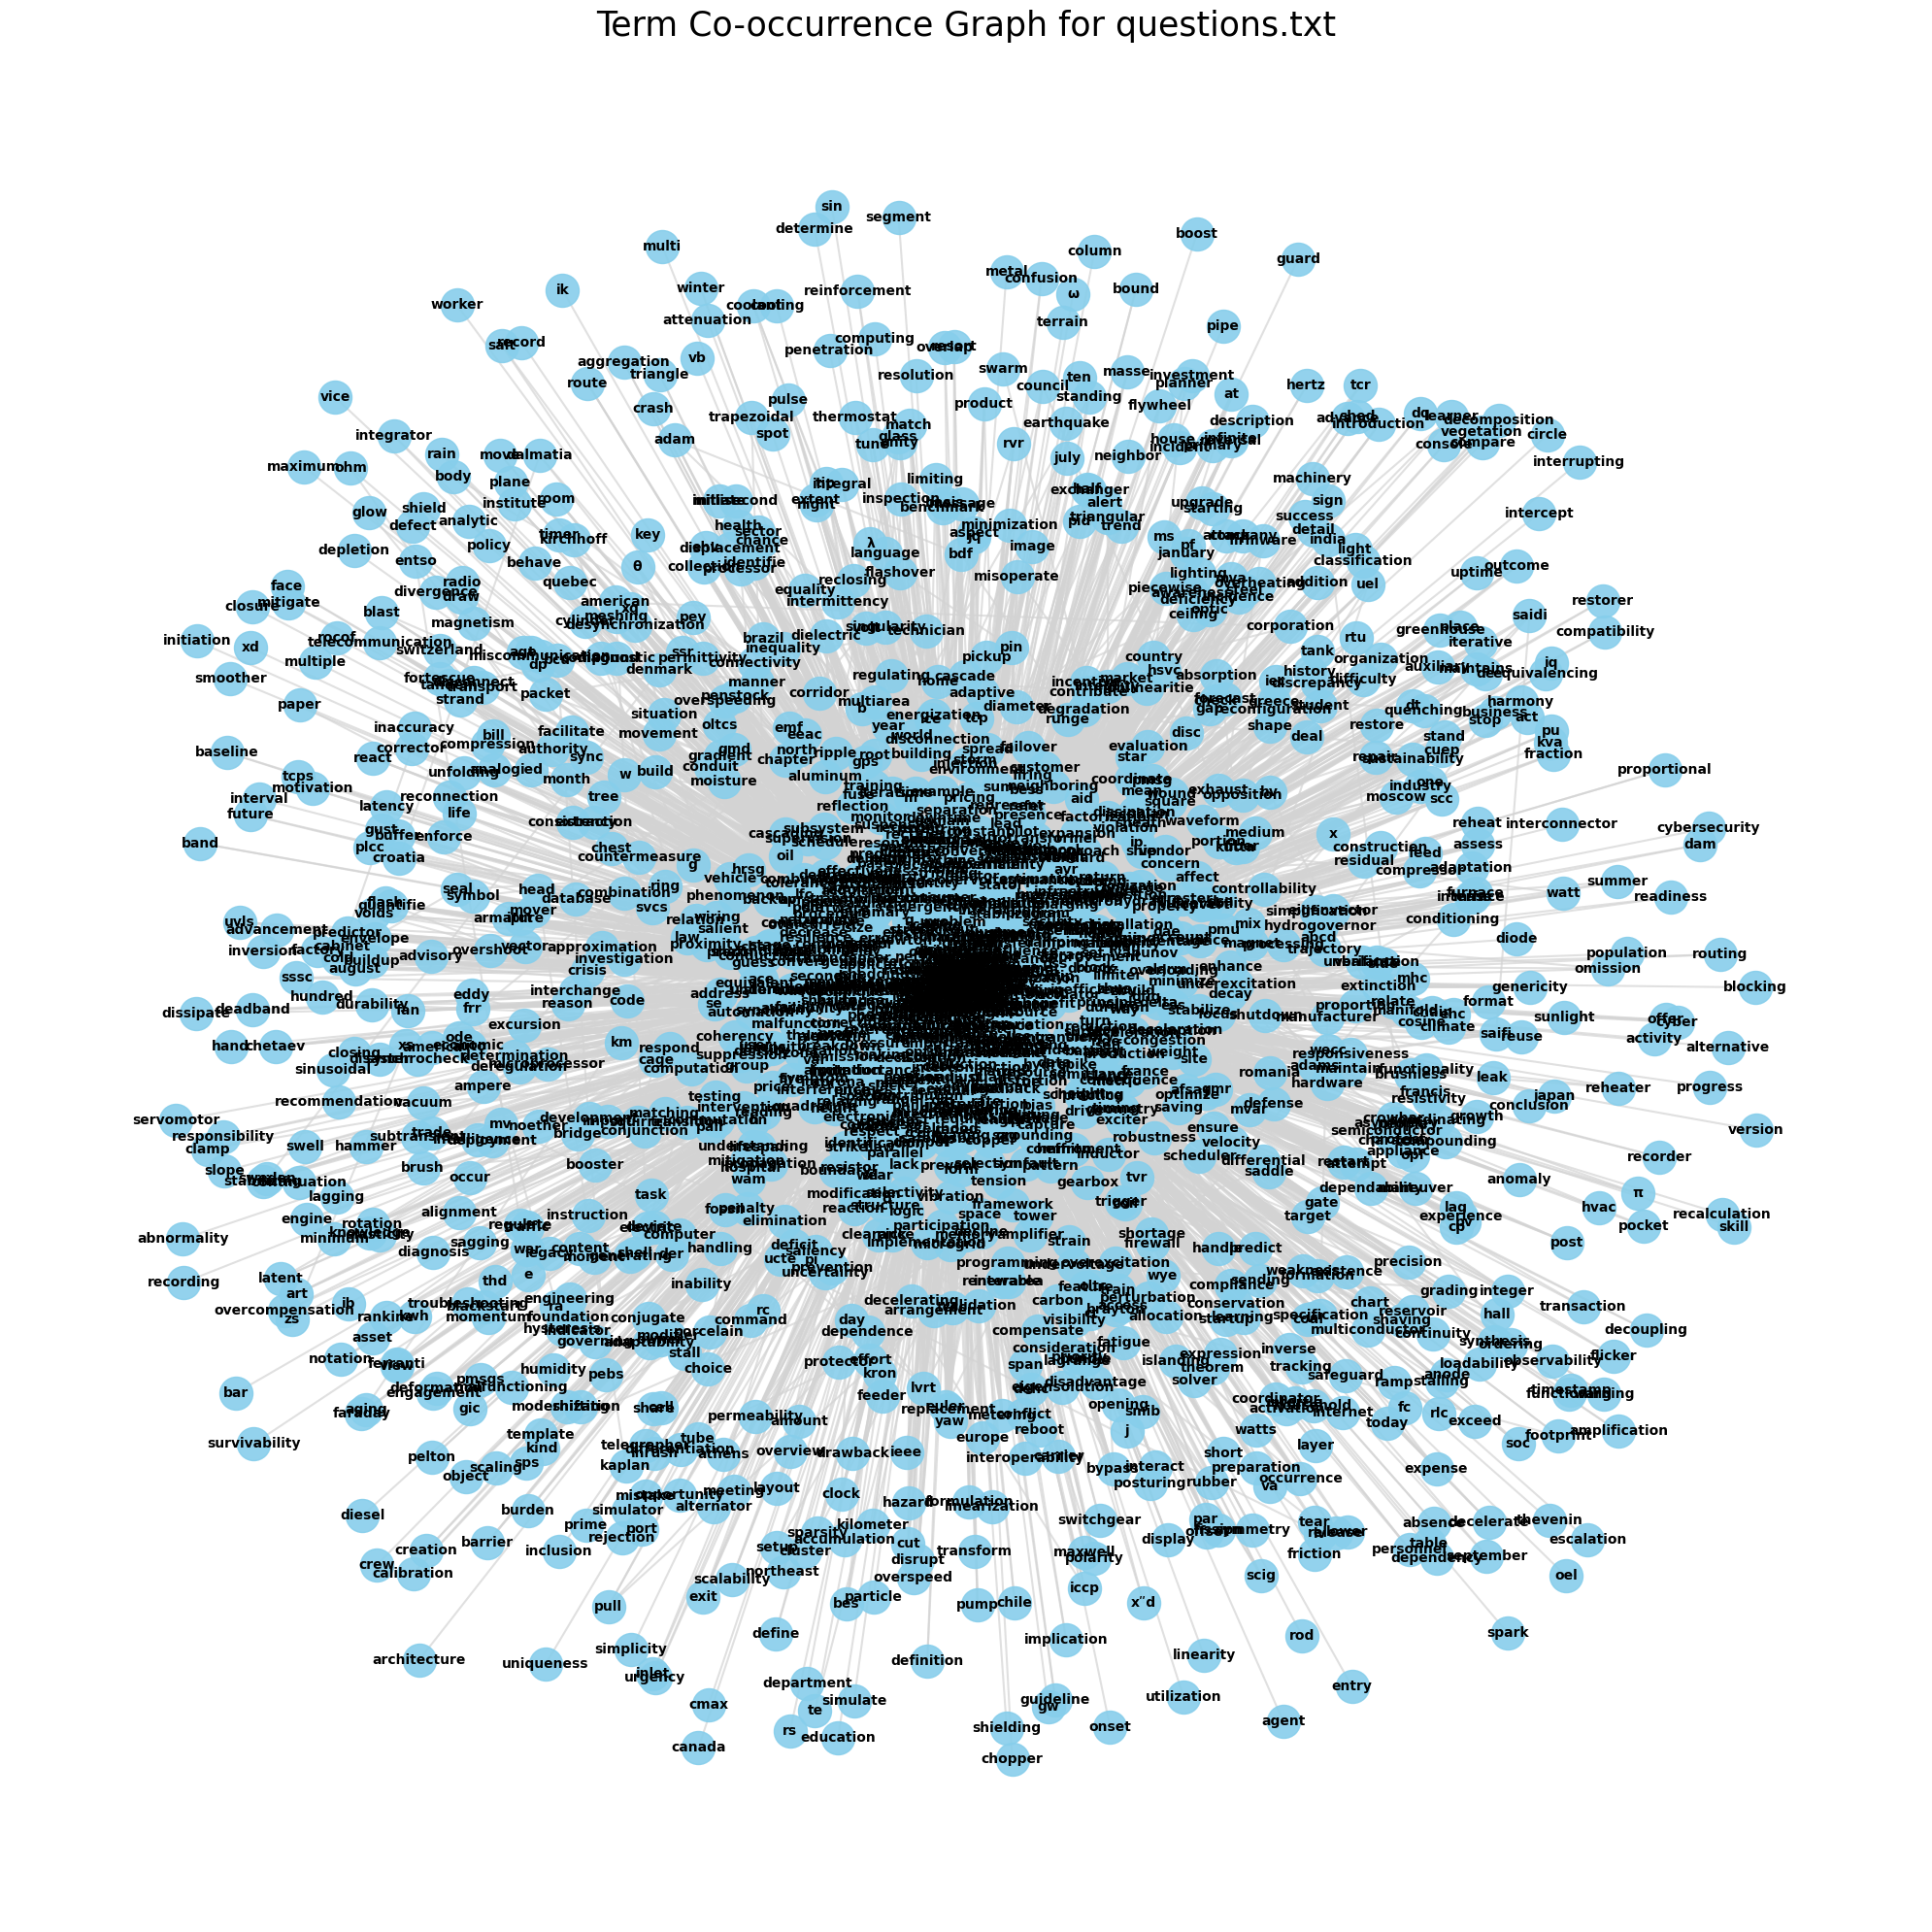

In [ ]:
#Thematic Analysis (Co-occurrence)

import re
import spacy
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt


try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("spaCy model not found. Please re-run the cell to ensure it's downloaded.")
    exit()


file_path = "questions.txt"

try:
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    documents = []
    for i in range(0, len(lines), 2):
        if i + 1 < len(lines):
            full_text = lines[i].strip() + " " + lines[i+1].strip()
            documents.append(full_text)

    print(f"Loaded and processed {len(documents)} Q&A pairs from {file_path}.\n")


    def extract_key_terms_spacy(text):
        doc = nlp(text.lower())
        key_terms = []
        for token in doc:
            if token.pos_ in {'NOUN', 'PROPN'} and not token.is_stop and token.is_alpha:
                key_terms.append(token.lemma_)
        return list(set(key_terms))

    term_lists = [extract_key_terms_spacy(doc) for doc in documents]


    G = nx.Graph()
    min_co_occurrence = 5

    co_occurrence_counts = Counter()
    for terms in term_lists:
        for i in range(len(terms)):
            for j in range(i + 1, len(terms)):
                term1, term2 = sorted((terms[i], terms[j]))
                co_occurrence_counts[(term1, term2)] += 1

    for (term1, term2), count in co_occurrence_counts.items():
        if count >= min_co_occurrence:
            G.add_edge(term1, term2, weight=count)

    print(f"Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    print("Each edge represents terms that appeared together in at least 5 Q&A pairs.\n")



    if G.number_of_nodes() > 0:
        plt.figure(figsize=(20, 20))
        pos = nx.spring_layout(G, k=0.2, iterations=30)


        nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=600, alpha=0.9)
        nx.draw_networkx_edges(G, pos, edge_color='lightgray', alpha=0.7, width=1.5)
        nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif', font_weight='bold')

        plt.title(f'Term Co-occurrence Graph for {file_path}', size=25)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("Graph is empty. Consider lowering the 'min_co_occurrence' threshold.")

except FileNotFoundError:
    print(f"Error: File not found at '{file_path}'. Please upload it to your Colab environment.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [ ]:
# Step 1: Install spaCy and its English language model
!pip install spacy networkx matplotlib
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 90.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Loaded and processed 27080 Q&A pairs from questions.txt.

Full graph built with 1545 nodes and 39430 edges.

Created a simplified graph with the top 50 most connected nodes.


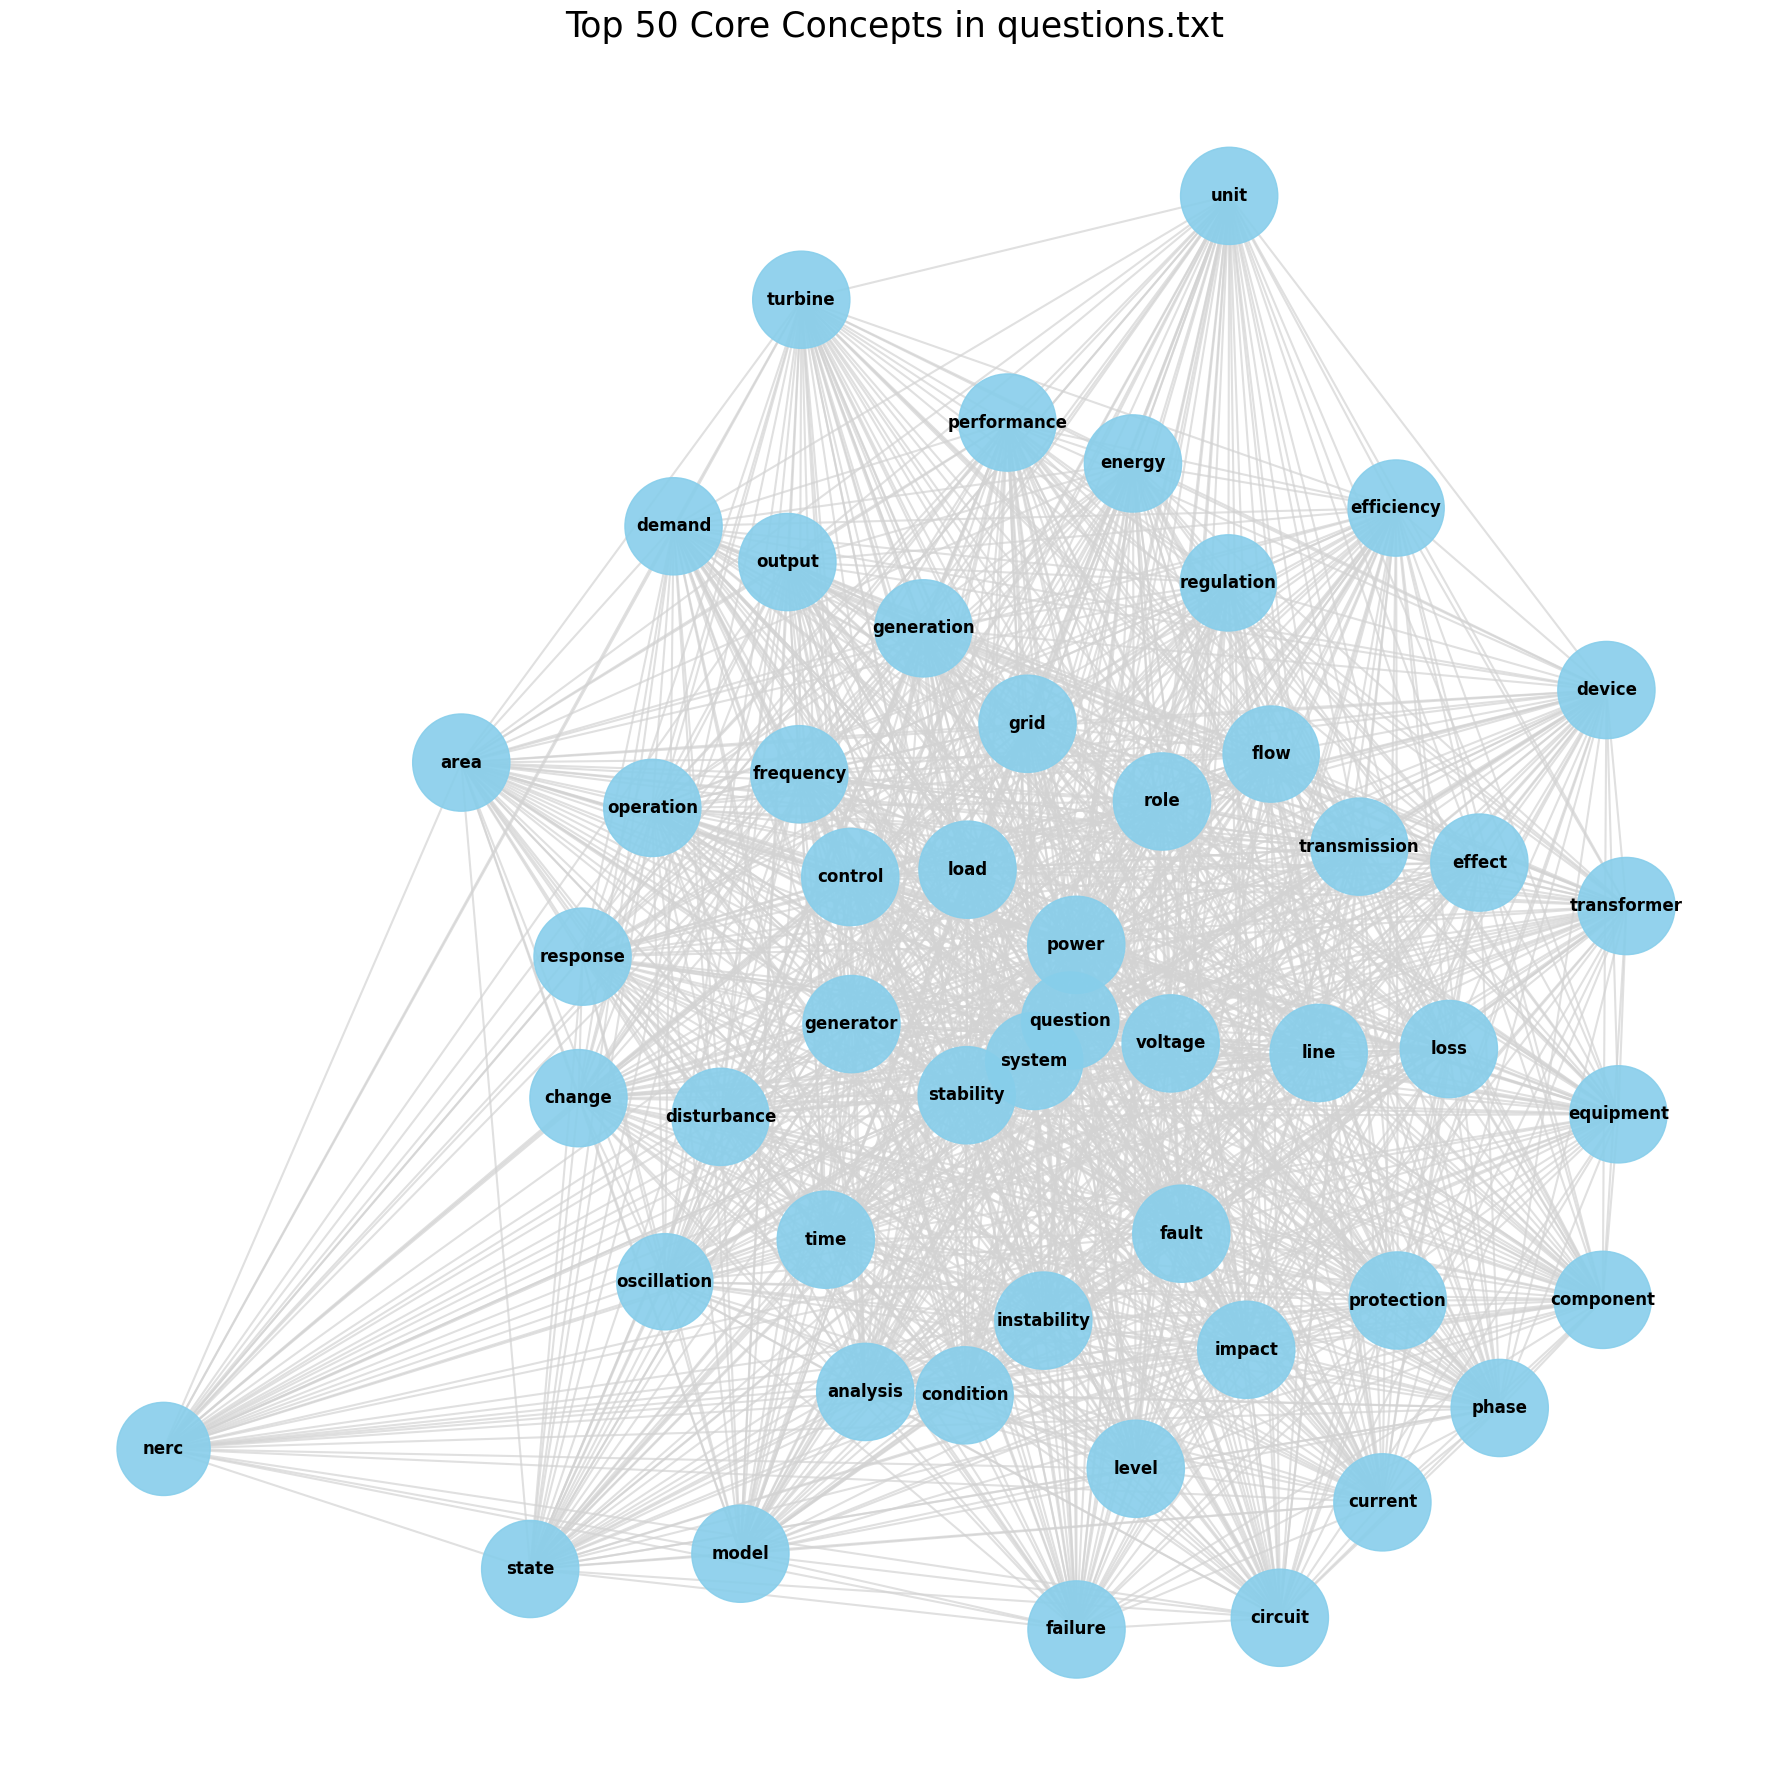

In [ ]:
#Thematic Analysis (Co-occurrence)
import re
import spacy
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("spaCy model not found. Please re-run the cell to ensure it's downloaded.")
    exit()

file_path = "questions.txt"

try:
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    documents = []
    for i in range(0, len(lines), 2):
        if i + 1 < len(lines):
            full_text = lines[i].strip() + " " + lines[i+1].strip()
            documents.append(full_text)

    print(f"Loaded and processed {len(documents)} Q&A pairs from {file_path}.\n")

    def extract_key_terms_spacy(text):
        doc = nlp(text.lower())
        key_terms = []
        for token in doc:
            if token.pos_ in {'NOUN', 'PROPN'} and not token.is_stop and token.is_alpha:
                key_terms.append(token.lemma_)
        return list(set(key_terms))

    term_lists = [extract_key_terms_spacy(doc) for doc in documents]


    G_full = nx.Graph()
    min_co_occurrence = 5

    co_occurrence_counts = Counter()
    for terms in term_lists:
        for i in range(len(terms)):
            for j in range(i + 1, len(terms)):
                term1, term2 = sorted((terms[i], terms[j]))
                co_occurrence_counts[(term1, term2)] += 1

    for (term1, term2), count in co_occurrence_counts.items():
        if count >= min_co_occurrence:
            G_full.add_edge(term1, term2, weight=count)

    print(f"Full graph built with {G_full.number_of_nodes()} nodes and {G_full.number_of_edges()} edges.\n")


    if G_full.number_of_nodes() > 0:

        degrees = dict(G_full.degree())

        top_n = 50
        if G_full.number_of_nodes() > top_n:
            top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:top_n]

            G_simplified = G_full.subgraph(top_nodes)
            print(f"Created a simplified graph with the top {len(G_simplified.nodes())} most connected nodes.")
        else:
            G_simplified = G_full
            print("Graph is small enough, visualizing all nodes.")

        plt.figure(figsize=(18, 18))
        pos = nx.spring_layout(G_simplified, k=0.5, iterations=100, seed=42)

        node_sizes = [v * 100 for v in dict(G_simplified.degree()).values()]

        nx.draw_networkx_nodes(G_simplified, pos, node_color='skyblue', node_size=node_sizes, alpha=0.9)
        nx.draw_networkx_edges(G_simplified, pos, edge_color='lightgray', alpha=0.7, width=1.5)
        nx.draw_networkx_labels(G_simplified, pos, font_size=12, font_family='sans-serif', font_weight='bold')

        plt.title(f'Top 50 Core Concepts in {file_path}', size=25)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    else:
        print("Graph is empty.")

except FileNotFoundError:
    print(f"Error: File not found at '{file_path}'. Please upload it to your Colab environment.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [ ]:
# Syntactic Divergence Analysis (Dependency Parsing)

import spacy
from spacy import displacy


try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("spaCy model not found. Run the previous cell to download it.")
    exit()



question = "What is the primary risk of operating a generator with a compromised exciter?"
answer = "Operating a generator with a faulty exciter can lead to voltage instability, which in turn risks causing a regional blackout if not properly mitigated by protective relays."

print("--- Dependency Parse for the Question ---")
doc_q = nlp(question)
displacy.render(doc_q, style="dep", jupyter=True, options={'distance': 90})

print("\n--- Dependency Parse for the Answer ---")
doc_a = nlp(answer)
displacy.render(doc_a, style="dep", jupyter=True, options={'distance': 100})

--- Dependency Parse for the Question ---



--- Dependency Parse for the Answer ---


In [ ]:
# Thematic Analysis Bipartite Community Detection
import spacy
import networkx as nx
from networkx.algorithms import community
from collections import Counter


try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("spaCy model not found. Run the first cell to download it.")
    exit()

file_path = "questions.txt"

try:
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()


    questions = {}
    term_lists = {}
    for i in range(0, len(lines), 2):
        if i + 1 < len(lines):
            q_id = f"Q-{i//2 + 1}"
            question_text = lines[i].strip()
            questions[q_id] = question_text

            doc = nlp(question_text.lower())
            key_terms = list(set([
                token.lemma_ for token in doc
                if token.pos_ in {'NOUN', 'PROPN'} and not token.is_stop and token.is_alpha
            ]))
            term_lists[q_id] = key_terms


    B = nx.Graph()

    B.add_nodes_from(questions.keys(), bipartite=0)
    all_terms = set(term for sublist in term_lists.values() for term in sublist)
    B.add_nodes_from(all_terms, bipartite=1)


    for q_id, terms in term_lists.items():
        for term in terms:
            B.add_edge(q_id, term)

    print(f"Built bipartite graph with {len(questions)} questions and {len(all_terms)} unique terms.\n")



    communities = community.greedy_modularity_communities(B)


    question_communities = sorted(
        [[node for node in c if node.startswith('Q-')] for c in communities],
        key=len,
        reverse=True
    )

    print(f"Found {len(question_communities)} question clusters.\n--- Top 5 Clusters ---")


    for i, cluster in enumerate(question_communities[:5]):
        if not cluster: continue


        cluster_terms = []
        for q_id in cluster:
            cluster_terms.extend(term_lists[q_id])


        topic_label = [term for term, count in Counter(cluster_terms).most_common(5)]

        print(f"\n## Cluster {i+1} ({len(cluster)} questions)")
        print(f"   Topic: {', '.join(topic_label)}")
        print(f"   Sample Question: '{questions[cluster[0]]}'")

except FileNotFoundError:
    print(f"Error: File not found at '{file_path}'. Please upload it.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Built bipartite graph with 27080 questions and 2624 unique terms.

Found 10395 question clusters.
--- Top 5 Clusters ---

## Cluster 1 (4666 questions)
   Topic: question, system, stability, power, generator
   Sample Question: '"question": "How does the Z bus method help in evaluating transmission network robustness during contingencies?",'

## Cluster 2 (3848 questions)
   Topic: question, voltage, system, power, line
   Sample Question: '"question": "Why is the transmission-loss equation important in economic operation?",'

## Cluster 3 (3667 questions)
   Topic: question, system, power, fault, protection
   Sample Question: '"question": "How are transformer equivalent circuit values obtained?",'

## Cluster 4 (3630 questions)
   Topic: question, system, power, load, control
   Sample Question: '{"question": "What challenges exist in implementing voltage control in distribution systems?", "answer": "Challenges include slow response times and limited control over reactive power resou

Found 10464 clusters. Visualizing a sample from the top 5.



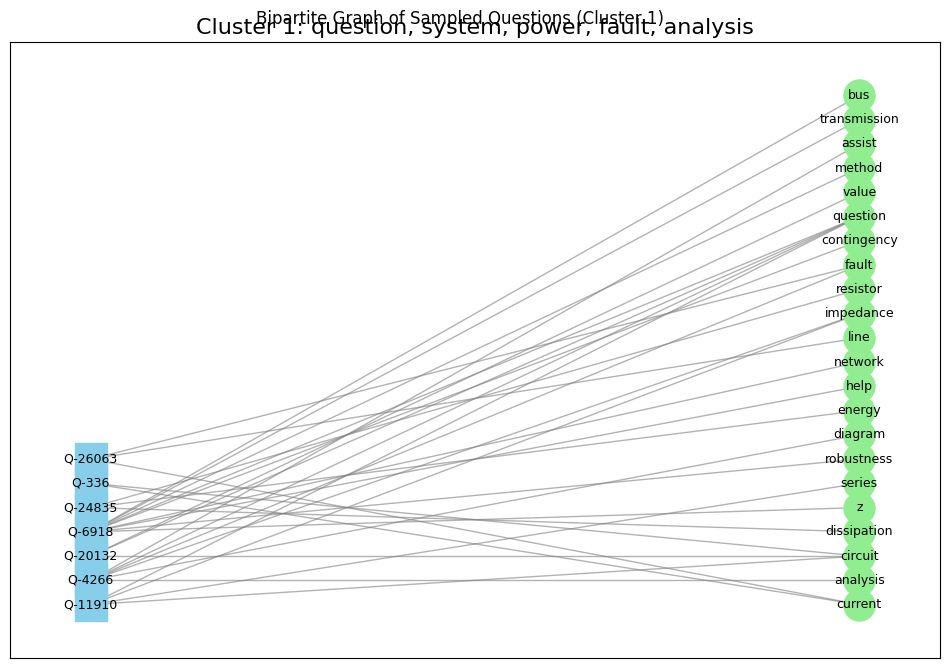

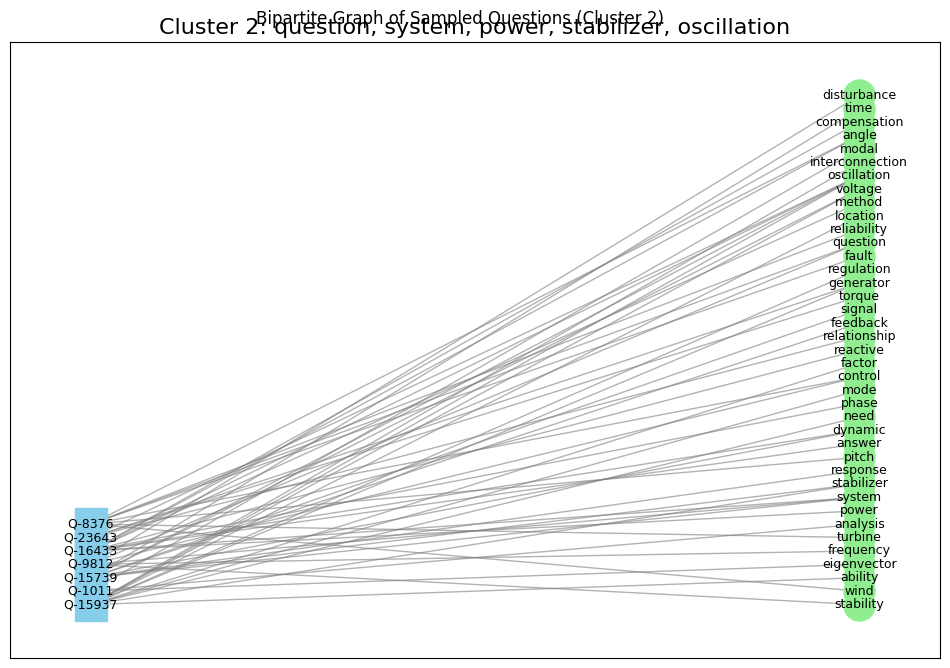

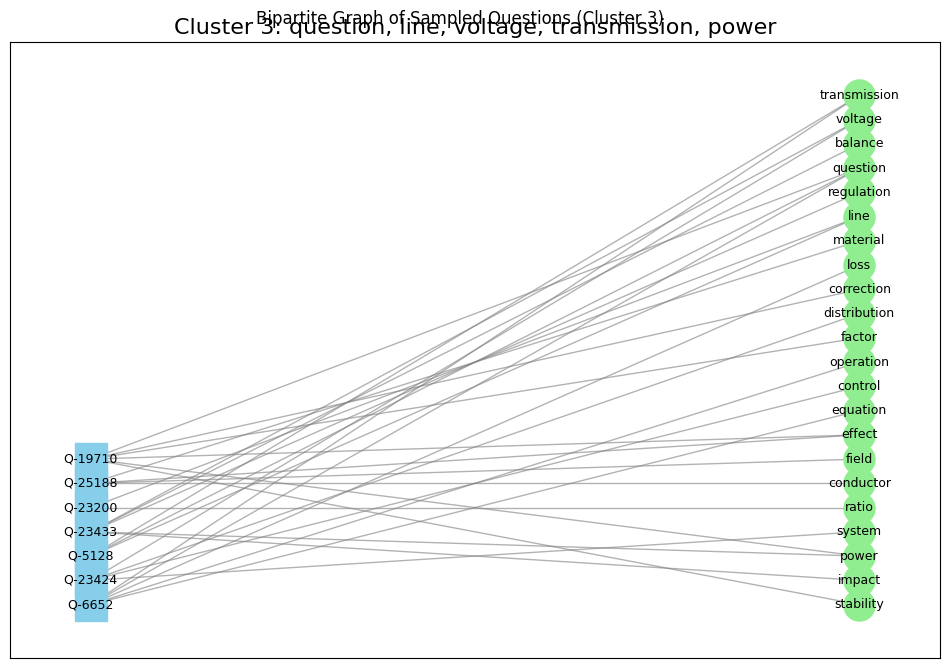

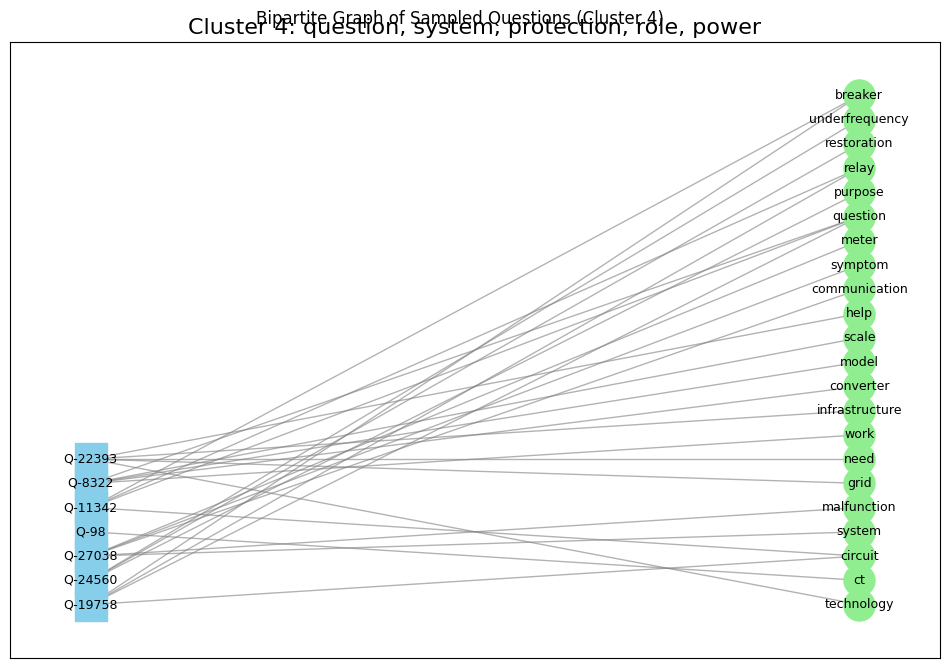

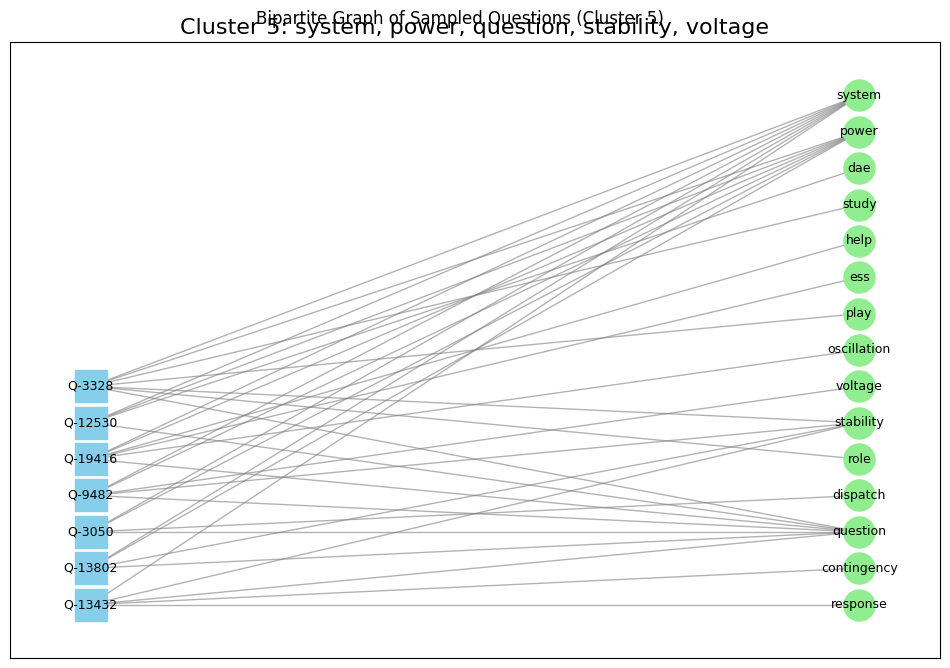

In [ ]:
#Thematic Analysis (C Bipartite Community Detection Graphs)
import spacy
import networkx as nx
from networkx.algorithms import community
from collections import Counter
import matplotlib.pyplot as plt


try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("spaCy model not found. Run the first cell to download it.")
    exit()

file_path = "questions.txt"

try:
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()


    questions = {}
    term_lists = {}
    for i in range(0, len(lines), 2):
        if i + 1 < len(lines):
            q_id = f"Q-{i//2 + 1}"
            question_text = lines[i].strip()

            if question_text.startswith('{"question":'):
                question_text = question_text.split('",')[0].replace('{"question": "', '')
            questions[q_id] = question_text

            doc = nlp(question_text.lower())
            key_terms = list(set([
                token.lemma_ for token in doc
                if token.pos_ in {'NOUN', 'PROPN'} and not token.is_stop and token.is_alpha
            ]))
            term_lists[q_id] = key_terms


    B = nx.Graph()
    B.add_nodes_from(questions.keys(), bipartite=0)
    all_terms = set(term for sublist in term_lists.values() for term in sublist)
    B.add_nodes_from(all_terms, bipartite=1)
    for q_id, terms in term_lists.items():
        for term in terms:
            B.add_edge(q_id, term)

    communities = community.greedy_modularity_communities(B)
    question_communities = sorted(
        [[node for node in c if node.startswith('Q-')] for c in communities],
        key=len,
        reverse=True
    )

    print(f"Found {len(question_communities)} clusters. Visualizing a sample from the top 5.\n")

    top_n_clusters = 5
    for i, cluster in enumerate(question_communities[:top_n_clusters]):
        if not cluster: continue


        cluster_terms_all = []
        for q_id in cluster:
            cluster_terms_all.extend(term_lists[q_id])
        topic_label = [term for term, count in Counter(cluster_terms_all).most_common(5)]


        sample_size = 7
        question_sample = cluster[:sample_size]

        term_sample = []
        for q_id in question_sample:
            term_sample.extend(term_lists[q_id])
        term_sample = list(set(term_sample))

        nodes_for_subgraph = question_sample + term_sample
        G_sample = B.subgraph(nodes_for_subgraph)


        plt.figure(figsize=(12, 8))

        pos = {}
        pos.update((node, (1, i)) for i, node in enumerate(question_sample))
        pos.update((node, (2, i)) for i, node in enumerate(term_sample))

        nx.draw_networkx_nodes(G_sample, pos, nodelist=question_sample, node_color='skyblue', node_shape='s', node_size=500, label='Questions')
        nx.draw_networkx_nodes(G_sample, pos, nodelist=term_sample, node_color='lightgreen', node_size=500, label='Key Terms')
        nx.draw_networkx_edges(G_sample, pos, edge_color='gray', alpha=0.6)
        nx.draw_networkx_labels(G_sample, pos, font_size=9)

        plt.title(f"Cluster {i+1}: {', '.join(topic_label)}", size=16)
        plt.suptitle(f"Bipartite Graph of Sampled Questions (Cluster {i+1})", y=0.92)
        plt.show()

except FileNotFoundError:
    print(f"Error: File not found at '{file_path}'. Please upload it.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Found 10464 clusters. Visualizing and saving a sample from the top 5.



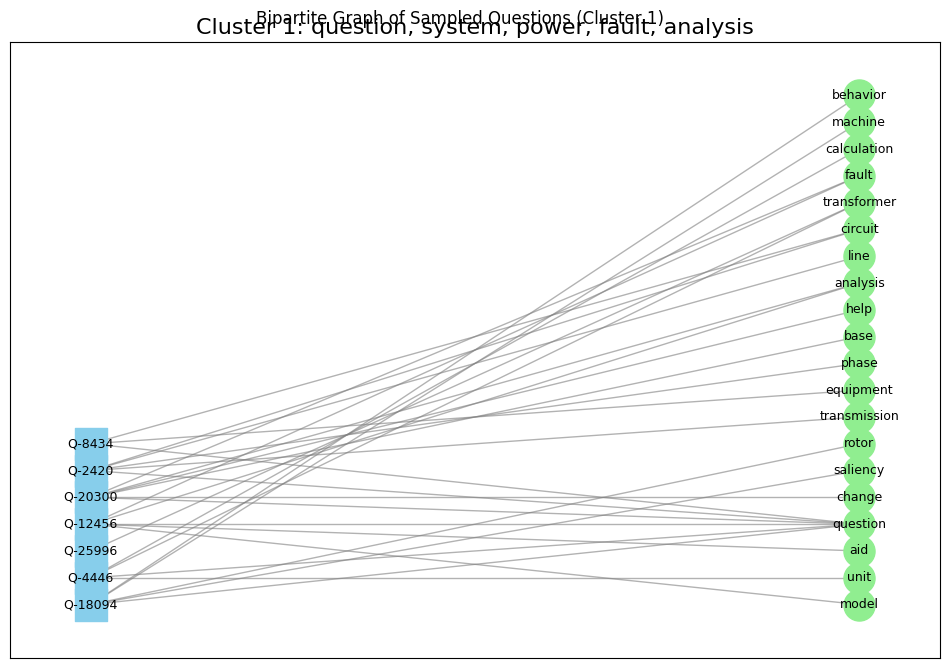

Successfully saved graph for Cluster 1 as 'cluster_1_visualization_high_res.png'


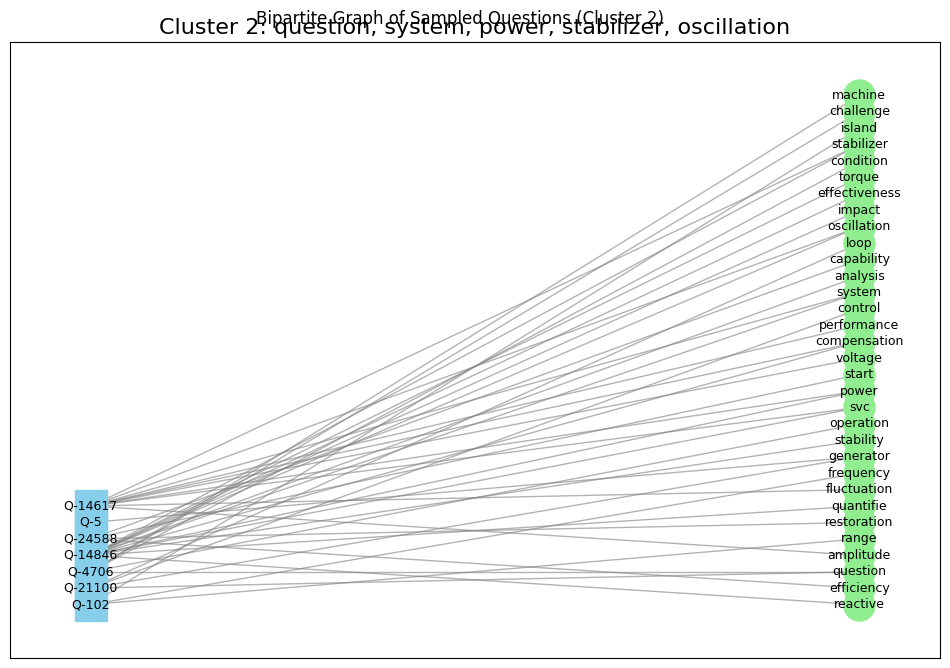

Successfully saved graph for Cluster 2 as 'cluster_2_visualization_high_res.png'


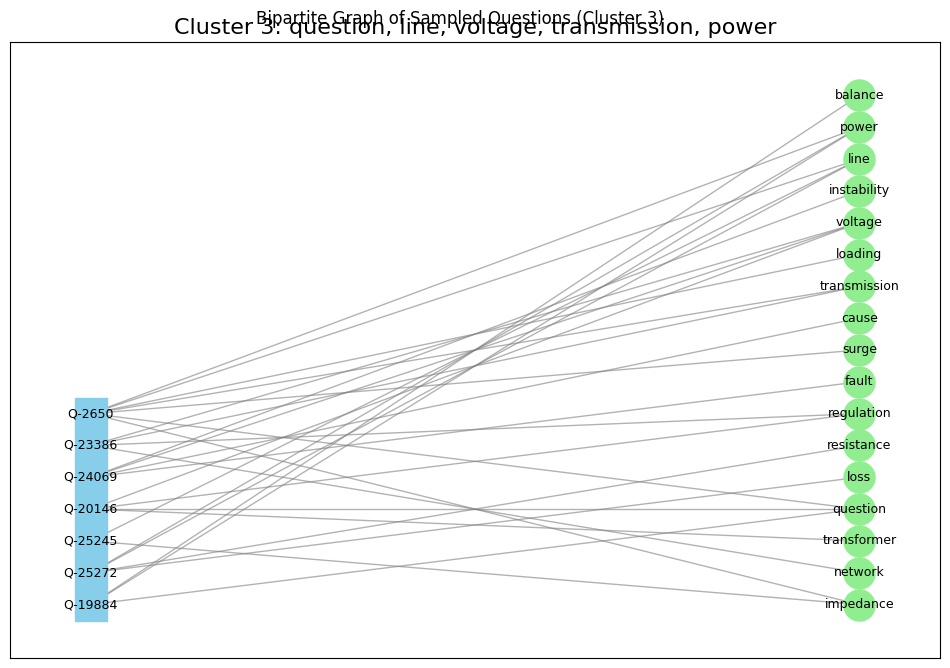

Successfully saved graph for Cluster 3 as 'cluster_3_visualization_high_res.png'


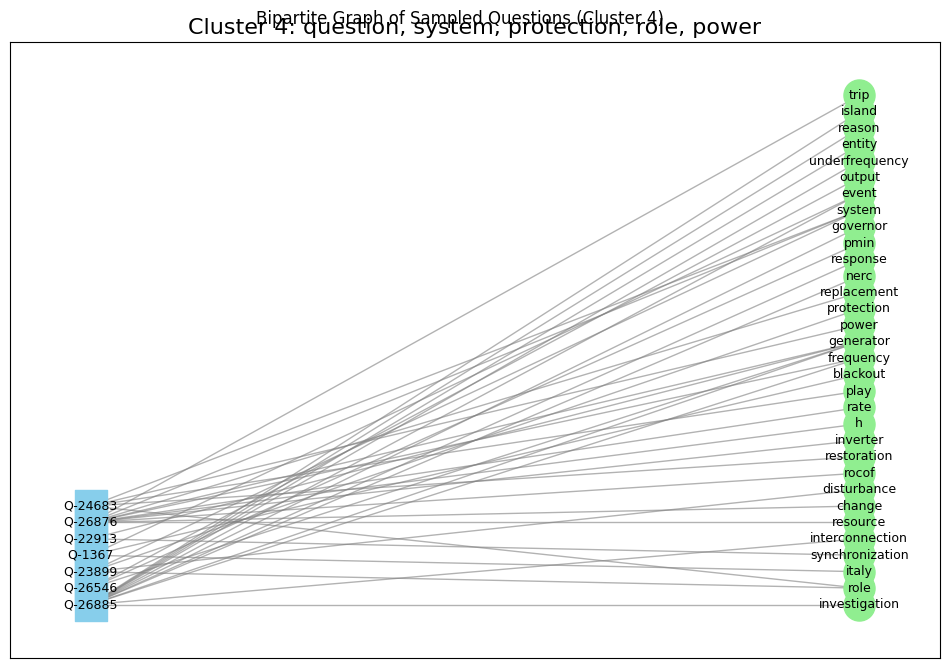

Successfully saved graph for Cluster 4 as 'cluster_4_visualization_high_res.png'


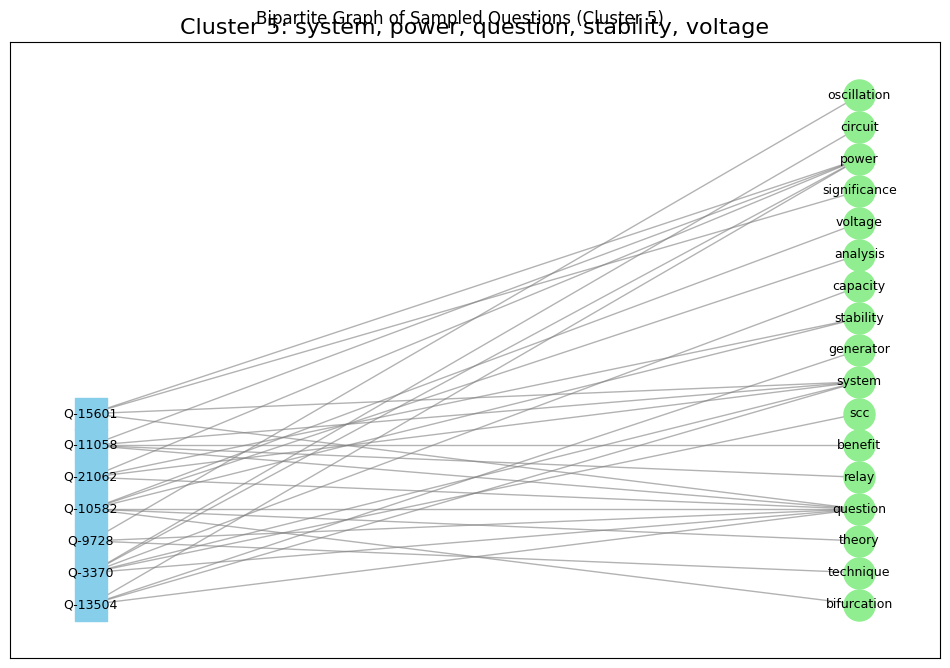

Successfully saved graph for Cluster 5 as 'cluster_5_visualization_high_res.png'


In [ ]:



import spacy
import networkx as nx
from networkx.algorithms import community
from collections import Counter
import matplotlib.pyplot as plt


try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("spaCy model not found. Run the first cell to download it.")
    exit()

file_path = "questions.txt"

try:
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()


    questions = {}
    term_lists = {}
    for i in range(0, len(lines), 2):
        if i + 1 < len(lines):
            q_id = f"Q-{i//2 + 1}"
            question_text = lines[i].strip()
            # Clean up the question text if it's in JSON format
            if question_text.startswith('{"question":'):
                question_text = question_text.split('",')[0].replace('{"question": "', '')
            questions[q_id] = question_text

            doc = nlp(question_text.lower())
            key_terms = list(set([
                token.lemma_ for token in doc
                if token.pos_ in {'NOUN', 'PROPN'} and not token.is_stop and token.is_alpha
            ]))
            term_lists[q_id] = key_terms


    B = nx.Graph()
    B.add_nodes_from(questions.keys(), bipartite=0)
    all_terms = set(term for sublist in term_lists.values() for term in sublist)
    B.add_nodes_from(all_terms, bipartite=1)
    for q_id, terms in term_lists.items():
        for term in terms:
            B.add_edge(q_id, term)

    communities = community.greedy_modularity_communities(B)
    question_communities = sorted(
        [[node for node in c if node.startswith('Q-')] for c in communities],
        key=len,
        reverse=True
    )

    print(f"Found {len(question_communities)} clusters. Visualizing and saving a sample from the top 5.\n")


    top_n_clusters = 5
    for i, cluster in enumerate(question_communities[:top_n_clusters]):
        if not cluster: continue


        cluster_terms_all = []
        for q_id in cluster:
            cluster_terms_all.extend(term_lists[q_id])
        topic_label = [term for term, count in Counter(cluster_terms_all).most_common(5)]


        sample_size = 7
        question_sample = cluster[:sample_size]

        term_sample = []
        for q_id in question_sample:
            term_sample.extend(term_lists[q_id])
        term_sample = list(set(term_sample))

        nodes_for_subgraph = question_sample + term_sample
        G_sample = B.subgraph(nodes_for_subgraph)

        # --- Visualize the Graph for This Cluster ---
        plt.figure(figsize=(12, 8))

        pos = {}
        pos.update((node, (1, i)) for i, node in enumerate(question_sample))
        pos.update((node, (2, i)) for i, node in enumerate(term_sample))

        nx.draw_networkx_nodes(G_sample, pos, nodelist=question_sample, node_color='skyblue', node_shape='s', node_size=500, label='Questions')
        nx.draw_networkx_nodes(G_sample, pos, nodelist=term_sample, node_color='lightgreen', node_size=500, label='Key Terms')
        nx.draw_networkx_edges(G_sample, pos, edge_color='gray', alpha=0.6)
        nx.draw_networkx_labels(G_sample, pos, font_size=9)

        plt.title(f"Cluster {i+1}: {', '.join(topic_label)}", size=16)
        plt.suptitle(f"Bipartite Graph of Sampled Questions (Cluster {i+1})", y=0.92)


        output_filename = f"cluster_{i+1}_visualization_high_res.png"
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')

        plt.show()

        print(f"Successfully saved graph for Cluster {i+1} as '{output_filename}'")


except FileNotFoundError:
    print(f"Error: File not found at '{file_path}'. Please upload it.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Analysis for: Power System Theory ---
Total questions analyzed: 27080
Other                       46.23
Causal Reasoning            23.72
Definition/Factual          23.52
Procedural                   4.93
Calculation/Quantitative     0.99
Comparative                  0.61


--- Analysis for: NERC Operational Insight ---
Total questions analyzed: 2494
Other                       69.93
Causal Reasoning            16.60
Definition/Factual           9.82
Procedural                   1.92
Calculation/Quantitative     1.40
Comparative                  0.32


--- Analysis for: Reasoning-based Case ---
Total questions analyzed: 395
Definition/Factual          50.38
Causal Reasoning            22.78
Other                       16.96
Comparative                  6.84
Procedural                   2.28
Calculation/Quantitative     0.76




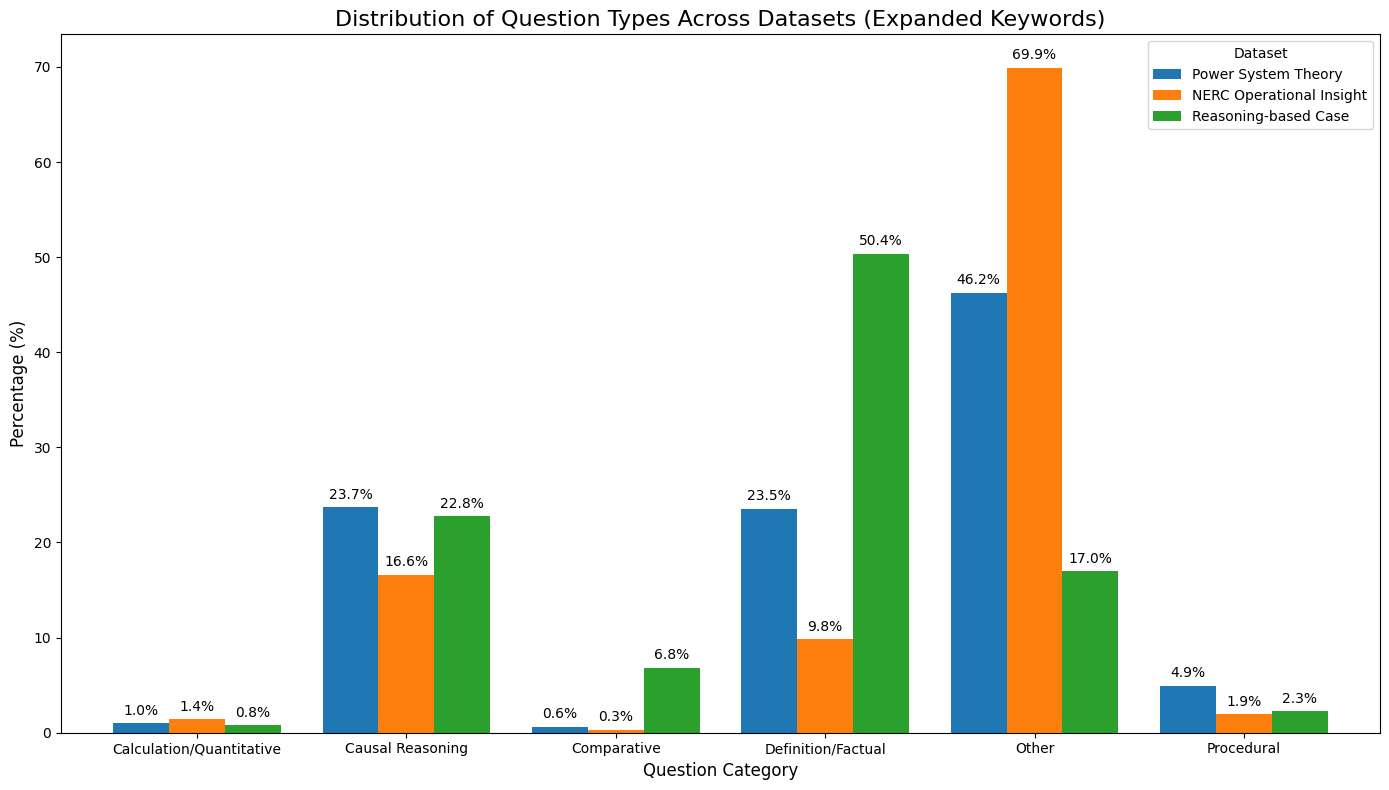

Graph successfully saved as 'question_distribution_improved.png' in high resolution.


In [ ]:



import spacy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("spaCy model not found. Please run a previous cell to download it.")
    exit()


def classify_question(question_text):
    """Classifies a question into predefined categories based on an expanded keyword list."""
    q_lower = question_text.lower()

    causal_keywords = [
        'why', 'how does', 'what causes', 'what is the effect', 'what happens when',
        'what are the consequences', 'what is the impact', 'what is the result of',
        'what is the reason for', 'what is the relationship between', 'how did',
        'lead to', 'impact of', 'result of', 'consequence of', 'reason for', 'affect', 'due to',
        'influence of', 'factor in', 'contributes to'
    ]
    procedural_keywords = [
        'how to', 'how are', 'how is', 'how can', 'what are the steps', 'what is the process',
        'what is the procedure', 'method for', 'approach to', 'implementing', 'designing',
        'obtaining', 'developing', 'creating', 'building', 'way to'
    ]
    comparative_keywords = [
        'compare', 'what is the difference', 'distinguish between', 'relationship between',
        'advantages and disadvantages', 'pros and cons', 'versus', 'vs.', 'than', 'similar to',
        'in contrast to', 'relative to'
    ]
    calc_keywords = [
        'calculate', 'what is the value', 'what is the magnitude', 'what is the frequency',
        'what is the percentage', 'how much', 'how many', 'determine the', 'compute the',
        'equation for', 'formula for', 'find the value', 'what quantity'
    ]
    def_keywords = [
        'what is', 'what are', 'describe', 'define', 'what is the role of', 'what is the function of',
        'identify the', 'list the', 'what does... mean', 'explain the', 'what type of'
    ]


    if any(kw in q_lower for kw in causal_keywords) or q_lower.startswith('how '):
        return "Causal Reasoning"
    if any(kw in q_lower for kw in procedural_keywords):
        return "Procedural"
    if any(kw in q_lower for kw in comparative_keywords):
        return "Comparative"
    if any(kw in q_lower for kw in calc_keywords):
        return "Calculation/Quantitative"
    if any(kw in q_lower for kw in def_keywords) or q_lower.startswith(('what ', 'which ', 'who ', 'when ', 'where ')):
        return "Definition/Factual"

    return "Other"

files_to_process = ["questions.txt", "Nerc questions.txt", "questions reasoning.txt"]
legend_map = {
    "questions.txt": "Power System Theory",
    "Nerc questions.txt": "NERC Operational Insight",
    "questions reasoning.txt": "Reasoning-based Case"
}
all_results = {}

for file_path in files_to_process:
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()

        questions = []
        for i in range(0, len(lines), 2):
            if i + 1 < len(lines):
                q_text = lines[i].strip()
                if q_text.startswith('{"question":'):
                    q_text = q_text.split('",')[0].replace('{"question": "', '')
                questions.append(q_text)

        if not questions:
            continue

        categories = [classify_question(q) for q in questions]
        series = pd.Series(categories)
        distribution = series.value_counts(normalize=True) * 100

        legend_name = legend_map.get(file_path, file_path)
        all_results[legend_name] = distribution

        print(f"--- Analysis for: {legend_name} ---")
        print(f"Total questions analyzed: {len(questions)}")
        print(distribution.round(2).to_string())
        print("\n")

    except FileNotFoundError:
        print(f"Warning: File '{file_path}' not found. Skipping.\n")
    except Exception as e:
        print(f"An error occurred while processing {file_path}: {e}\n")


if all_results:
    df_results = pd.DataFrame(all_results).fillna(0)
    ax = df_results.plot(kind='bar', figsize=(14, 8), rot=0, width=0.8)

    plt.title('Distribution of Question Types Across Datasets (Expanded Keywords)', fontsize=16)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.xlabel('Question Category', fontsize=12)
    plt.legend(title='Dataset')

    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}%",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points')

    plt.tight_layout()

    output_filename = 'question_distribution_improved.png'
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')

    plt.show()

    print(f"Graph successfully saved as '{output_filename}' in high resolution.")